#### Estimation par dérivée seconde

In [ ]:
data, names = f_clusters_transform(data)

In [ ]:
results = pd.DataFrame(columns=["Sum_of_squared_distances"], index=np.arange(1,40+1))



K = np.arange(1,50+1)
for k in tqdm (K,  
           desc="Calcul de l'inertie",  
           ascii=False, ncols=100) : 
    km = KMeans(n_clusters=k, n_init=100) 
    km = km.fit(data) 
    results.loc[k,"Sum_of_squared_distances"] = km.inertia_    

In [ ]:
for line in range (2, len(results)):
    results.loc[line, "sec_deriv"] = results.loc[line-1, "Sum_of_squared_distances"] +  results.loc[line+1, "Sum_of_squared_distances"] - 2*results.loc[line, "Sum_of_squared_distances"]

In [ ]:
results.head(10)

In [ ]:
plt.figure(figsize=(8, 6))
ax = results.Sum_of_squared_distances.plot(title="Evolution de l'inertie en fonction du nombre de clusters créés")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Inertie")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
ax = results.loc[2:,"sec_deriv"].plot(title="Dérivée seconde discrete")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Dérivée seconde")
plt.show()

In [19]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import sqlite3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
import sys
from tqdm import tqdm
import warnings

# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, k_fine:int=15, k_seuil:int=15, k_end:int=50, n_init:int=10) :
    """
    df : dataframe à entrer
    k_fine : dernier point à calculer avec n_init
    k_seuil : point à partir duquel est calculé k_opt (premier point à tracer avec k=1)
    k_end : dernier point à calculer. De k_fine+1 à k_end, n_init=n_init//2      
    """   
    data, names = f_clusters_transform(df)
    
    if k_fine >= data.shape[0] // 2 :
        k_fine = data.shape[0] // 2

    if k_end > data.shape[0]:
        k_end = data.shape[0]

    results = pd.DataFrame(columns=["Sum_of_squared_distances"], index=np.arange(1,k_end+1))

    K = np.arange(1,k_fine+1)
    for k in tqdm (K,  
               desc="Calcul de l'inertie",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=n_init) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_

    K_seuil = np.arange(k_fine, k_end+1)
    for k in tqdm (K_seuil,  
               desc="Calcul du seuil…",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=n_init//2) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_

    # Normalisation de Sum_of_squared_distances entre 1 et k_fine pour avoir un graph orthonormé
    scaler = MinMaxScaler(feature_range=(0,k_end-1))
    results["score_norm"] = scaler.fit_transform(results["Sum_of_squared_distances"].values.reshape(-1,1))

    # Liste vide pour les valeurs k_opt pour chaque calcul entre k_fine et k_fine+1
    k_opt_list=[]

    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Calcul de 
    for k in range(k_seuil, k_end+1,2) :

        a = (results.loc[k,"score_norm"] - results.loc[1,"score_norm"]) / (k-1)
        b = results.loc[1,"score_norm"] - a

        distance = []
        for point in range(2,k):
            p_a = -1 / a
            p_b = results.loc[point,"score_norm"]-point*p_a
            x_intersec = (p_b-b)/(a-p_a)
            distance.append(np.sqrt((x_intersec-point)**2 + (a*x_intersec+b - results.loc[point,"score_norm"])**2))
        distance = np.array(distance) 
        k_opt = np.where(distance == distance.max())[0][0]+2

        p_b_max = results.loc[k_opt,"score_norm"]-k_opt*p_a
        x_intersec = (p_b_max-b)/(a-p_a)
        y_intersec = p_a*x_intersec + p_b_max

        k_opt_list.append(k_opt)
        ax1.plot([1,k], [a*1+b , a*k+b])
        ax1.plot([k_opt, x_intersec], [results.loc[k_opt,"score_norm"], y_intersec] )

    sns.countplot(x= k_opt_list)    
    k_opt = pd.Series(k_opt_list).value_counts().index[0]

    ax1.plot(results.score_norm)
    ax1.scatter(k_opt, results.loc[k_opt,"score_norm"],s=100, c='red', marker='X')    
    ax1.axvline(x=k_opt, ymax = results.loc[k_opt,"score_norm"]/results.loc[1,"score_norm"] , color='gray',linestyle='--')
    _=fig.suptitle(f"Nombre de cluster optimal : {k_opt}")  
 
    return k_opt, results.score_norm
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    
def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Chargement des données

In [4]:
region = "HDF"

In [5]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 120 piezos pour le clustering dans le dataframe.


## Analyse du nombre optimal de clusters

Calcul du seuil…: 100%|█████████████████████████████████████████████| 76/76 [00:20<00:00,  3.64it/s]


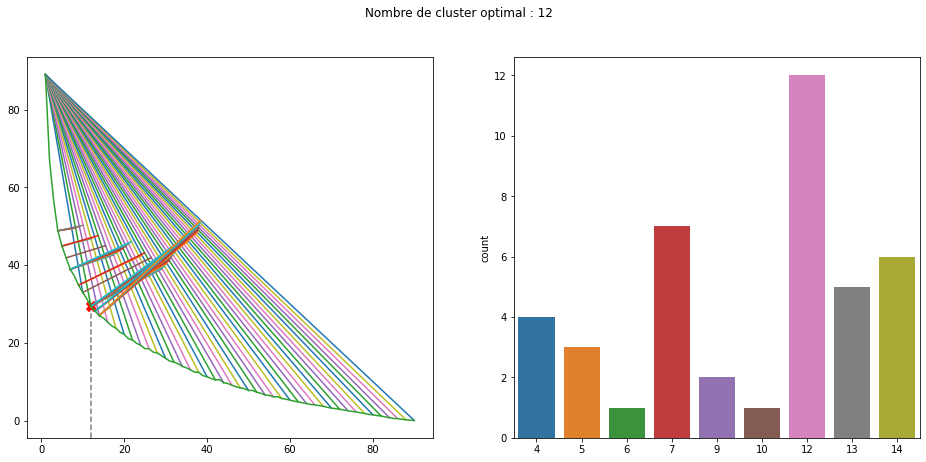

In [23]:
k_calc, results = f_clusters_coude(data, k_seuil=10, k_end=90, n_init=50)


In [14]:
pd.Series(coude).value_counts()

11    8
10    5
8     4
12    3
7     2
13    1
4     1
9     1
dtype: int64

## Création des clusters

In [15]:
# Choix du nombre de clusters à créer
nbre_clusters = 11

In [ ]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 200, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

## Affichage des clusters

In [ ]:
f_plot_clusters(data, cluster_table, cluster_centers)
#cluster_table.groupby("cluster").mean()

In [ ]:
#f_plot_all(data, cluster_table, cluster_centers)

## Filtre des chroniques avec score insuffisant

In [ ]:
plt.plot(cluster_table["MSE"].sort_values())

In [ ]:
# nbre de chroniques sous le seuil
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 0
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

data_opt = data.copy()

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 100, max_iter = 2000)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")
    
plt.plot(cluster_table["MSE"].sort_values())

In [ ]:
f_plot_clusters(data_opt, cluster_table, cluster_centers)

In [ ]:
sns.countplot(data = cluster_table, x = "cluster")

In [ ]:
#cluster_table.groupby("cluster").mean()

## Contrôle du nombre de clusters après éliminant des chroniques hors clusters

In [ ]:
coude, df = f_clusters_coude(data_opt, k_seuil=10, k_end=90, n_init=30)

In [ ]:
nbre_clusters = 11
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 200, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 0
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

data_opt = data.copy()

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 100, max_iter = 2000)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")

## Sous-clusters - SCORING

In [ ]:
scoring = pd.DataFrame(columns=cluster_centers.columns, index=cluster_centers.columns)
scoring = scoring.fillna(0)

# Itération du clustering en fonction de nbre_clusters
for iteration in range (2, nbre_clusters) :
    cluster_table_2, cluster_centers_2 = f_clusters_fit(cluster_centers, iteration)
    for line in cluster_table_2.index:
        for colonne in cluster_table_2.index:
            if line == colonne :
                pass
            elif cluster_table_2.cluster[line] == cluster_table_2.cluster[colonne]:
                scoring.loc[line, colonne] += ((iteration-1))
                
# Il y a nbre_clusters -3 itérations.
# Le score max est donc la suite 1+2+...+(nbre_clusters-2) = (nbre_clusters-2)*(nbre_clusters-2+1)/2)
scoring_pourc = round(scoring / ((nbre_clusters-2)*(nbre_clusters-1)/2),2)

In [ ]:
colors = ["snow", "mistyrose", "lightgreen", "limegreen", "darkgreen"]
colors = [mcolors.to_rgba(color) for color in colors]

custom_cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

_=sns.heatmap(scoring_pourc, cmap=custom_cmap, square=True, vmin=0, vmax=1)
cluster_table.cluster.value_counts()

### Création des listes de sous-clusters

In [ ]:
# Sous clusterisation

# Liste des listes de clusters
liste_liste = []
# Liste des clusters déjà affectés
list_inList = []

# Parcourt des clusters par nombre d'occurences dans les piezos
for line in cluster_table.cluster.value_counts().index:
    # liste pour le cluster/line en cours
    liste = []
    if line in list_inList :
        pass
    else :
        list_inList.append(line)
        liste.append(line)
        
        for colonne in cluster_table.cluster.value_counts().index:
            if colonne in list_inList :
                pass
            elif scoring_pourc.loc[f"{region}_{line}", f"{region}_{colonne}"] > 0.4 :
                liste.append(colonne)
                list_inList.append(colonne)
                
                # Boucle d'association secondaire si un cluster est éligible au cluster 2 (colonne) mais mais au cluster 1 (line)
                for colonne_2 in cluster_table.cluster.value_counts().index:
                    if colonne_2 in list_inList :
                        pass
                    elif scoring_pourc.loc[f"{region}_{colonne}", f"{region}_{colonne_2}"] > 0.4 :
                        liste.append(colonne_2)
                        list_inList.append(colonne_2)
                
        liste_liste.append(liste)
liste_liste

### Modification des libellés

In [ ]:
# Pour incrémentation littéraire
ch = "A"

liste_liste_2 = liste_liste.copy()

for index_sous_cluster, sous_cluster in enumerate (liste_liste):
    for index_cluster, cluster in enumerate (sous_cluster) :
        if len(sous_cluster) > 1:
            liste_liste_2[index_sous_cluster][index_cluster] = chr(ord(ch)+index_sous_cluster) + str(index_cluster+1)
        else :
            liste_liste_2[index_sous_cluster][index_cluster] = chr(ord(ch)+index_sous_cluster)

liste_liste_2_flat = []            
for index_sous_cluster in liste_liste_2 :
    liste_liste_2_flat += index_sous_cluster

for index, label in enumerate(liste_liste_2_flat) :
    liste_liste_2_flat[index] = f"{region}_" + liste_liste_2_flat[index]
    
# Liste des clusters d'ogine
liste_clusters = list(cluster_table.cluster.value_counts().index)
    
# Renommage    
cluster_table.replace(liste_clusters, liste_liste_2_flat, inplace=True)    

In [ ]:
liste_liste_2

In [ ]:
liste_liste_2_flat

## Sous-clusters - Dendogramme

In [ ]:
from scipy.cluster import hierarchy

In [ ]:
Z = hierarchy.linkage(cluster_centers.T, method='ward')
plt.figure()
dn = hierarchy.dendrogram(Z)

# Enregistrement des profils des clusters

In [ ]:
cluster_centers.columns = liste_liste_2_flat
cluster_centers.to_csv(f"./data/{region}_clusters.csv")

# Ajout à la bdd

In [ ]:
# Nom de la table
table = "cluster_kmeans"

In [ ]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

In [ ]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans
                    """
f_requete_sql(requete)